# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28 $\times$ 28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32 $\times$ 32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [33]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

In [34]:
# to use GPU, if available
device = 'cpu'
if torch.cuda.is_available():
    device=torch.device("cuda")

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [35]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [36]:
#from torch.utils.data import random_split
#train_ds, val_ds = random_split(train, [45000,5000])
#
#from torch.utils.data import DataLoader
#train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_ds, batch_size=64)

In [37]:
from sklearn.model_selection import train_test_split

# load the data set
def unpickle(filename):
    with open(filename, 'rb') as fp:
        data = pickle.load(fp, encoding='bytes')
    return data

data_directory = 'cifar-10-batches-py'
meta_data_dict = unpickle(data_directory + "/batches.meta")
label_names = meta_data_dict[b'label_names']
label_names = np.array(label_names)

train_data = None
train_filenames = []
train_labels = []

for i in range(1,6):
    train_data_dict = unpickle(data_directory + "/data_batch_" + str(i))
    if i == 1:
        train_data = train_data_dict[b'data']
    else:
        train_data = np.vstack((train_data, train_data_dict[b'data']))
    train_filenames += train_data_dict[b'filenames']
    train_labels += train_data_dict[b'labels']

train_data = train_data.reshape((len(train_data), 3, 32, 32))
train_data = np.rollaxis(train_data, 1, 4)
train_filenames = np.array(train_filenames)
train_labels = np.array(train_labels)
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X = torch.reshape(torch.from_numpy(train_data),(len(train_data),3,32,32))
y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.2)

In [38]:
print(X.shape,y.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

torch.Size([50000, 3, 32, 32]) (50000,)
torch.Size([40000, 3, 32, 32]) (40000,)
torch.Size([10000, 3, 32, 32]) (10000,)


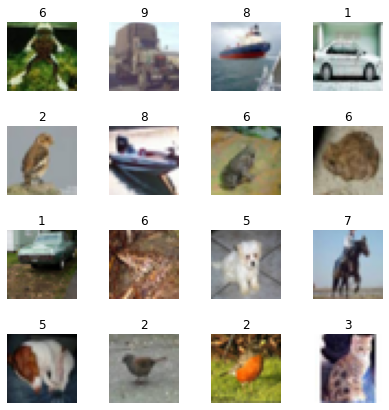

In [39]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
plt.figure(figsize = (7,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = random.randrange(0,X.shape[0])
    img = torch.reshape(X[index],(32,32,3))
    plt.imshow(img)
    plt.title(y[index])
    plt.axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Creating a Dataset Class


In [40]:
from torch.utils.data import Dataset
import torchvision

# define your dataset class

transformNorm = torchvision.transforms.Compose([torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) 

class CIFAR10_Dataset(Dataset):
    def __init__(self,x,y):
        self.X = transformNorm(x.float())
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,index):
        return self.X[index], self.y[index]

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [41]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3,8,3,padding='same')
        self.batchnorm2 = torch.nn.BatchNorm2d(8)
        self.pool3 = torch.nn.MaxPool2d(2,2) # 8,16,16
        self.conv4 = torch.nn.Conv2d(8,16,3,padding=1) # 16,16,16
        self.batchnorm5 = torch.nn.BatchNorm2d(16)
        self.conv6 = torch.nn.Conv2d(16,16,3,padding=1) # 16,16,16
        self.batchnorm7 = torch.nn.BatchNorm2d(16)
        self.pool8 = torch.nn.MaxPool2d(2,2) # 16,8,8
        self.conv9 = torch.nn.Conv2d(16,16,3,padding=1) # 16,8,8
        self.batchnorm10 = torch.nn.BatchNorm2d(16)
        self.pool11 = torch.nn.MaxPool2d(2,2) # 16,4,4
        self.conv12 = torch.nn.Conv2d(16,32,3,padding=1) # 32,4,4
        self.batchnorm13 = torch.nn.BatchNorm2d(32)
        self.conv14 = torch.nn.Conv2d(32,32,3,padding=1) # 32,4,4
        self.batchnorm15 = torch.nn.BatchNorm2d(32)
        self.pool16 = torch.nn.AvgPool2d(4,4) # 32,1,1
        self.fc17 = torch.nn.Linear(32,32) # 16,32
        self.batchnorm18 = torch.nn.BatchNorm1d(32)
        self.fc19 = torch.nn.Linear(32,16) # 16,16
        self.batchnorm20 = torch.nn.BatchNorm1d(16)
        self.fc21 = torch.nn.Linear(16,10)
        self.relu = torch.nn.ReLU()
    def forward(self,x):
        x.to(device)
        output = self.relu(self.batchnorm2(self.conv1(x)))
        output = self.pool3(output)
        output = self.relu(self.batchnorm5(self.conv4(output)))
        output = self.relu(self.batchnorm7(self.conv6(output)))
        output = self.pool8(output)
        output = self.relu(self.batchnorm10(self.conv9(output)))
        output = self.pool11(output)
        output = self.relu(self.batchnorm13(self.conv12(output)))
        output = self.relu(self.batchnorm15(self.conv14(output)))
        output = self.pool16(output)
        output = torch.reshape(output,(-1,32))
        output = self.relu(self.batchnorm18(self.fc17(output)))
        output = self.relu(self.batchnorm20(self.fc19(output)))
        output = self.fc21(output)
        output = torch.nn.functional.log_softmax(output,dim=1)
        return output

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [42]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    index = 0
    model.to(device)
    loss_values = list()
    epoch_list = list()
    start_epoch = 0
    num_epoch = 25
    for i in range(start_epoch, num_epoch + start_epoch):
        loss = 0
        for imgs, labels in train_loader:
            imgs, labels = torch.autograd.Variable(imgs).to(device),labels.to(device)
            labels = torch.reshape(labels,(-1,))
            out = model.forward(imgs)
            loss = criterion(out,labels)
            loss.to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if display_step and (index % display_step == 0):
                print('After epoch',i+1,', index = ', index,', loss = ', loss.item())
            index = index + 1
        epoch_list.append(i)
        loss_values.append(loss.item())
    return epoch_list, loss_values, index

## Prediction & Accuracy
Prediction function should predict outputputs using your trained model for a given **NumPy array** ```X_test``` and the outputput should be another **NumPy array**.

The accuracy function would be the same as before.

In [43]:
def predict(model, X_test):
    model.to('cpu')
    X_test1 = X_test.float().reshape(-1,3,32,32)
    model_score = model.forward(X_test1)
    scores = model_score.detach().numpy()
    preds = scores.argmax(axis = 1)
    return preds

In [44]:
def accuracy(pred, labels):
    acc = 0
    j = 0
    for i in pred:
        if i == labels[j]:
            acc += 1
        j += 1
    return 100*(acc/len(labels))

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


After epoch 1 , index =  0 , loss =  2.2588822841644287
After epoch 1 , index =  500 , loss =  1.8190884590148926
After epoch 2 , index =  1000 , loss =  2.057328939437866
After epoch 3 , index =  1500 , loss =  1.47339928150177
After epoch 4 , index =  2000 , loss =  1.6890612840652466
After epoch 5 , index =  2500 , loss =  1.4642271995544434
After epoch 5 , index =  3000 , loss =  1.6644142866134644
After epoch 6 , index =  3500 , loss =  1.463333010673523
After epoch 7 , index =  4000 , loss =  1.456198811531067
After epoch 8 , index =  4500 , loss =  1.4483612775802612
After epoch 9 , index =  5000 , loss =  1.522160530090332
After epoch 9 , index =  5500 , loss =  1.4656152725219727
After epoch 10 , index =  6000 , loss =  1.6520612239837646
After epoch 11 , index =  6500 , loss =  1.4898366928100586
After epoch 12 , index =  7000 , loss =  1.1921330690383911
After epoch 13 , index =  7500 , loss =  1.258985161781311
After epoch 13 , index =  8000 , loss =  1.3046249151229858
Aft

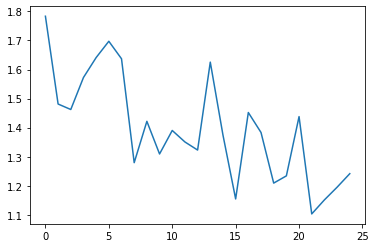

In [45]:
from torch.utils.data import DataLoader

model = ConvNet()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.RMSprop(model.parameters())

training_data = CIFAR10_Dataset(X_train,y_train)
training_dataLoader = DataLoader(training_data, batch_size = 64, shuffle= True)

x1,y1,i1 = train(model,optimizer,criterion,training_dataLoader,display_step=500)
plt.plot(x1,y1)

plt.show()

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [46]:
predictions = predict(model, X_test)
print("Accuracy for validation dataset: ", accuracy(predictions,y_test))

Accuracy for validation dataset:  52.25


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [47]:
# from google.colab import files
torch.save(model, 'ass_3.pt')
# files.download('ass_3.pt') # download the file from the Colab session for submission

Check if it got saved right!

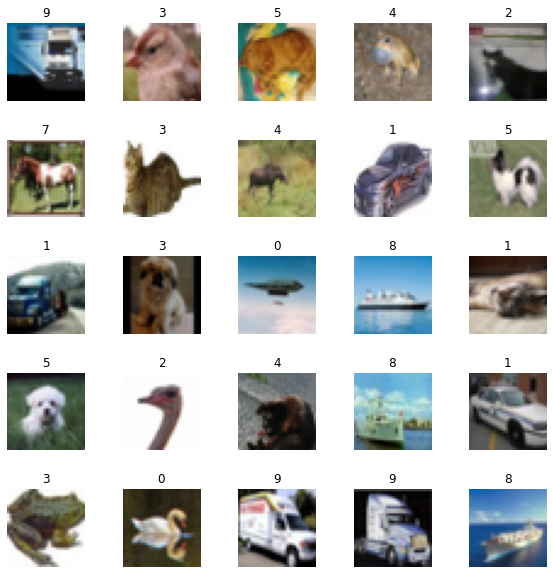

Accuracy for the complete set = 57.91666666666667


In [48]:
# load the model, use predict function
final_model = torch.load("ass_3.pt")

# testing on 60% splitted part of X
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y , stratify = y, test_size = 0.6)

predictions = predict(final_model,X_test1)
plt.figure(figsize = (10,10))
for i in range(1,26):
    rand_index = random.randrange(X_test1.shape[0])
    plt.subplot(5,5,i)
    plt.imshow(torch.reshape(X_test1[rand_index],(32,32,3)))
    plt.axis('off')
    plt.title(predictions[rand_index])
plt.subplots_adjust(hspace=0.5)
plt.show()
print(f'Accuracy for the complete set = {accuracy(predictions,y_test1)}')